In [50]:
! git clone https://github.com/stdereka/knowledge-distillation.git
! cp -r knowledge-distillation/dark_knowledge/ .
! cp -r knowledge-distillation/experiments/ .

fatal: destination path 'knowledge-distillation' already exists and is not an empty directory.


In [51]:
import sys
sys.path.insert(1, "/content/knowledge-distillation")

In [52]:
# Load data
! wget https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz
! tar zxf imagewoof2-320.tgz
# Check GPU
! nvidia-smi

--2020-09-23 13:26:35--  https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.67.78
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.67.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328288506 (313M) [application/x-tar]
Saving to: ‘imagewoof2-320.tgz.2’

imagewoof2-320.tgz. 100%[===================>] 313.08M  50.3MB/s    in 5.3s    

2020-09-23 13:26:40 (59.4 MB/s) - ‘imagewoof2-320.tgz.2’ saved [328288506/328288506]

Wed Sep 23 13:26:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |          

In [53]:
import sys
sys.path.insert(1, "/content/knowledge-distillation")

In [54]:
import torch
import random
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
import os
from training import train, predict, DistillationLoss
from models import *
from datasets import ImageDataset
from itertools import product

In [55]:
"""
Define globals and seed whatever I can seed
"""
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('Training on CPU')
    DEVICE = torch.device("cpu")
else:
    print('Training on GPU')
    DEVICE = torch.device("cuda")

SEED = 0
seed_everything(SEED)

TRAIN_DIR = Path('./imagewoof2-320/train')
TEST_DIR = Path('./imagewoof2-320/val')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.JPEG')))

# Shuffle dataset and teacher labels synchronously
train_val_files = random.Random(SEED).sample(train_val_files, len(train_val_files))
dark_knowledge_train = np.load("./dark_knowledge/resnet101_train_imagewoof.npy")
dark_knowledge_train = random.Random(SEED).sample(list(dark_knowledge_train), len(train_val_files))
dark_knowledge_train = np.array(dark_knowledge_train)
np.save("./dark_knowledge/resnet101_train_imagewoof.npy", dark_knowledge_train)

test_files = sorted(list(TEST_DIR.rglob('*.JPEG')))

train_val_labels = [path.parent.name for path in train_val_files]
LABEL_ENCODER = LabelEncoder()
LABEL_ENCODER.fit(train_val_labels)

N_CLASSES = LABEL_ENCODER.classes_.shape[0]

Training on GPU


In [56]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax = ax.flatten()

    ax[0].plot(history[:, 0], label="Train")
    ax[0].plot(history[:, 2], label="Val")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(history[:, 1], label="Train")
    ax[1].plot(history[:, 3], label="Val")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    ax[1].grid()

    plt.show()

Training with p = 0.01
83466 (of 11259978) trainable params


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2352: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch: 1, train_loss: 1.6375, val_loss: 1.7113, train_acc: 0.1333, val_acc: 0.1038
Epoch: 2, train_loss: 1.6073, val_loss: 1.4712, train_acc: 0.1222, val_acc: 0.3006
Epoch: 3, train_loss: 1.3526, val_loss: 1.2997, train_acc: 0.4667, val_acc: 0.3584
Epoch: 4, train_loss: 1.0787, val_loss: 0.9580, train_acc: 0.5667, val_acc: 0.5411
Epoch: 5, train_loss: 0.7495, val_loss: 0.9201, train_acc: 0.7333, val_acc: 0.4994
Epoch: 6, train_loss: 0.6396, val_loss: 0.9981, train_acc: 0.6444, val_acc: 0.5284
Epoch: 7, train_loss: 0.7303, val_loss: 0.7808, train_acc: 0.6778, val_acc: 0.6444
Epoch: 8, train_loss: 0.5872, val_loss: 0.7690, train_acc: 0.7556, val_acc: 0.6027
Epoch: 9, train_loss: 0.4586, val_loss: 0.6498, train_acc: 0.7556, val_acc: 0.5846
Epoch: 10, train_loss: 0.3727, val_loss: 0.6168, train_acc: 0.7889, val_acc: 0.6409
Epoch: 11, train_loss: 0.3380, val_loss: 0.5763, train_acc: 0.9111, val_acc: 0.7073
Epoch: 12, train_loss: 0.3041, val_loss: 0.5543, train_acc: 0.9222, val_acc: 0.7361
E

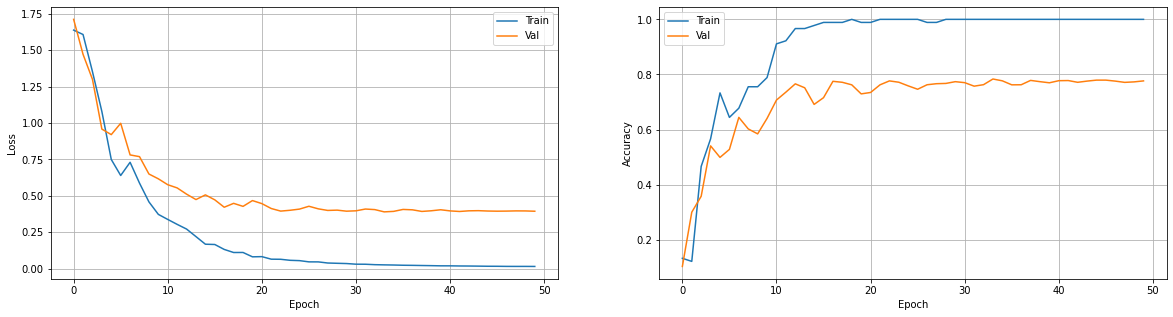

83466 (of 11259978) trainable params
Epoch: 1, train_loss: 2.4632, val_loss: 2.8366, train_acc: 0.1222, val_acc: 0.1038
Epoch: 2, train_loss: 2.6950, val_loss: 2.0828, train_acc: 0.1000, val_acc: 0.2476
Epoch: 3, train_loss: 1.9622, val_loss: 2.0974, train_acc: 0.3667, val_acc: 0.2041
Epoch: 4, train_loss: 1.6870, val_loss: 1.6529, train_acc: 0.3222, val_acc: 0.4077
Epoch: 5, train_loss: 1.2853, val_loss: 1.4226, train_acc: 0.6333, val_acc: 0.5294
Epoch: 6, train_loss: 1.0917, val_loss: 1.2812, train_acc: 0.6889, val_acc: 0.4617
Epoch: 7, train_loss: 0.7991, val_loss: 1.0839, train_acc: 0.6889, val_acc: 0.6513
Epoch: 8, train_loss: 0.6756, val_loss: 0.9699, train_acc: 0.7667, val_acc: 0.6378
Epoch: 9, train_loss: 0.3998, val_loss: 0.9858, train_acc: 0.8889, val_acc: 0.6460
Epoch: 10, train_loss: 0.2841, val_loss: 1.0091, train_acc: 0.9111, val_acc: 0.6421
Epoch: 11, train_loss: 0.2413, val_loss: 0.9886, train_acc: 0.9111, val_acc: 0.6635
Epoch: 12, train_loss: 0.1391, val_loss: 0.9166,

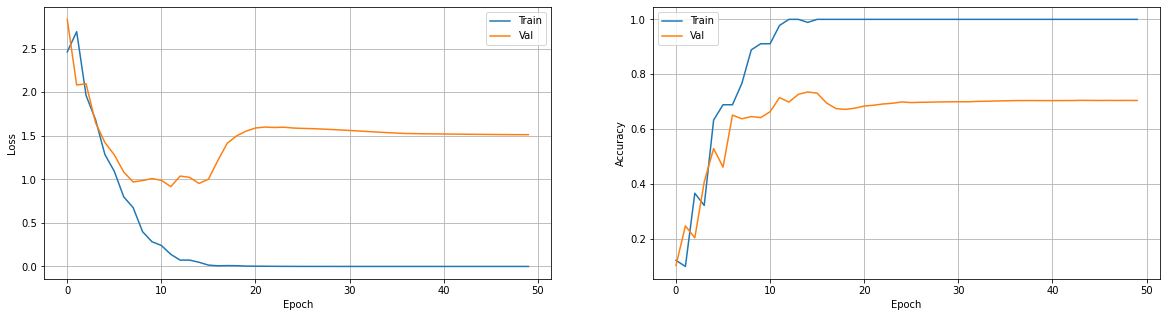

Training with p = 0.05
83466 (of 11259978) trainable params


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2352: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch: 1, train_loss: 1.5635, val_loss: 1.2646, train_acc: 0.1552, val_acc: 0.2734
Epoch: 2, train_loss: 1.2130, val_loss: 0.8994, train_acc: 0.3459, val_acc: 0.5462
Epoch: 3, train_loss: 0.7505, val_loss: 0.6315, train_acc: 0.6208, val_acc: 0.6528
Epoch: 4, train_loss: 0.5390, val_loss: 0.5946, train_acc: 0.7228, val_acc: 0.7142
Epoch: 5, train_loss: 0.4381, val_loss: 0.4116, train_acc: 0.7694, val_acc: 0.7620
Epoch: 6, train_loss: 0.3046, val_loss: 0.3706, train_acc: 0.8293, val_acc: 0.7959
Epoch: 7, train_loss: 0.2641, val_loss: 0.3922, train_acc: 0.8647, val_acc: 0.7852
Epoch: 8, train_loss: 0.2643, val_loss: 0.4004, train_acc: 0.8736, val_acc: 0.7727
Epoch: 9, train_loss: 0.2958, val_loss: 0.4206, train_acc: 0.8492, val_acc: 0.7781
Epoch: 10, train_loss: 0.2442, val_loss: 0.3282, train_acc: 0.8936, val_acc: 0.8162
Epoch: 11, train_loss: 0.1848, val_loss: 0.3160, train_acc: 0.9268, val_acc: 0.8226
Epoch: 12, train_loss: 0.1775, val_loss: 0.3795, train_acc: 0.9335, val_acc: 0.7839
E

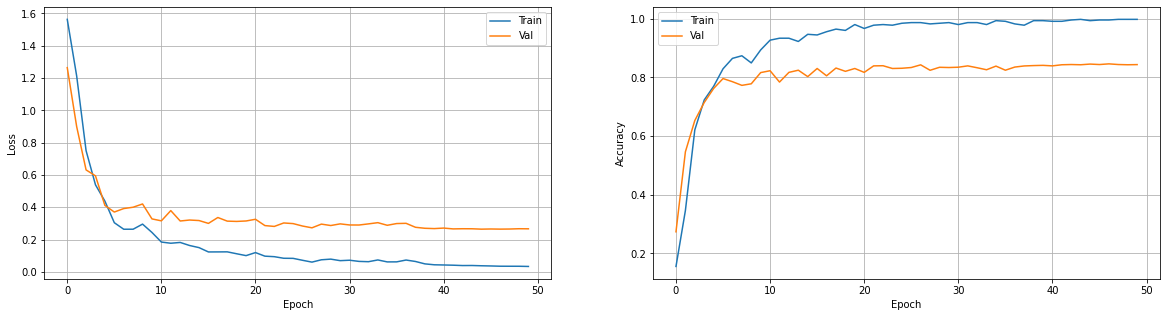

83466 (of 11259978) trainable params
Epoch: 1, train_loss: 2.5211, val_loss: 2.0918, train_acc: 0.1286, val_acc: 0.2110
Epoch: 2, train_loss: 1.9626, val_loss: 1.6466, train_acc: 0.2971, val_acc: 0.4037
Epoch: 3, train_loss: 1.3942, val_loss: 1.3039, train_acc: 0.4568, val_acc: 0.5177
Epoch: 4, train_loss: 1.0864, val_loss: 1.0280, train_acc: 0.5854, val_acc: 0.6256
Epoch: 5, train_loss: 0.7671, val_loss: 0.7941, train_acc: 0.7073, val_acc: 0.6925
Epoch: 6, train_loss: 0.5352, val_loss: 0.8267, train_acc: 0.7960, val_acc: 0.7259
Epoch: 7, train_loss: 0.4639, val_loss: 0.8122, train_acc: 0.8271, val_acc: 0.7473
Epoch: 8, train_loss: 0.4081, val_loss: 0.5687, train_acc: 0.8625, val_acc: 0.8030
Epoch: 9, train_loss: 0.2881, val_loss: 0.6662, train_acc: 0.9002, val_acc: 0.7819
Epoch: 10, train_loss: 0.2149, val_loss: 0.6670, train_acc: 0.9224, val_acc: 0.7933
Epoch: 11, train_loss: 0.1383, val_loss: 0.5915, train_acc: 0.9557, val_acc: 0.8229
Epoch: 12, train_loss: 0.0861, val_loss: 0.6435,

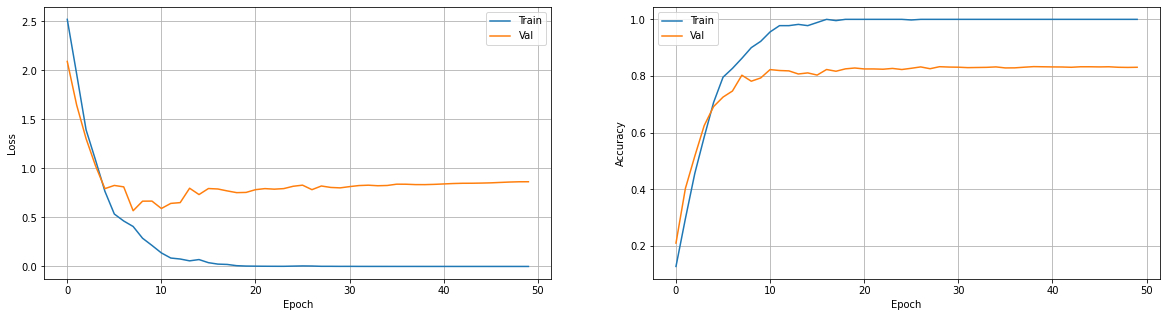

Training with p = 0.1
83466 (of 11259978) trainable params


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2352: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch: 1, train_loss: 1.1259, val_loss: 0.9028, train_acc: 0.4102, val_acc: 0.5136
Epoch: 2, train_loss: 0.5176, val_loss: 0.3748, train_acc: 0.7184, val_acc: 0.8066
Epoch: 3, train_loss: 0.2717, val_loss: 0.3163, train_acc: 0.8714, val_acc: 0.8366
Epoch: 4, train_loss: 0.2002, val_loss: 0.2520, train_acc: 0.8991, val_acc: 0.8649
Epoch: 5, train_loss: 0.1721, val_loss: 0.3045, train_acc: 0.9235, val_acc: 0.8412
Epoch: 6, train_loss: 0.1962, val_loss: 0.2869, train_acc: 0.9002, val_acc: 0.8173
Epoch: 7, train_loss: 0.1570, val_loss: 0.2237, train_acc: 0.9246, val_acc: 0.8804
Epoch: 8, train_loss: 0.1175, val_loss: 0.2498, train_acc: 0.9523, val_acc: 0.8590
Epoch: 9, train_loss: 0.1085, val_loss: 0.2194, train_acc: 0.9590, val_acc: 0.8748
Epoch: 10, train_loss: 0.0930, val_loss: 0.2400, train_acc: 0.9645, val_acc: 0.8621
Epoch: 11, train_loss: 0.0937, val_loss: 0.2146, train_acc: 0.9756, val_acc: 0.8727
Epoch: 12, train_loss: 0.0856, val_loss: 0.2103, train_acc: 0.9734, val_acc: 0.8720
E

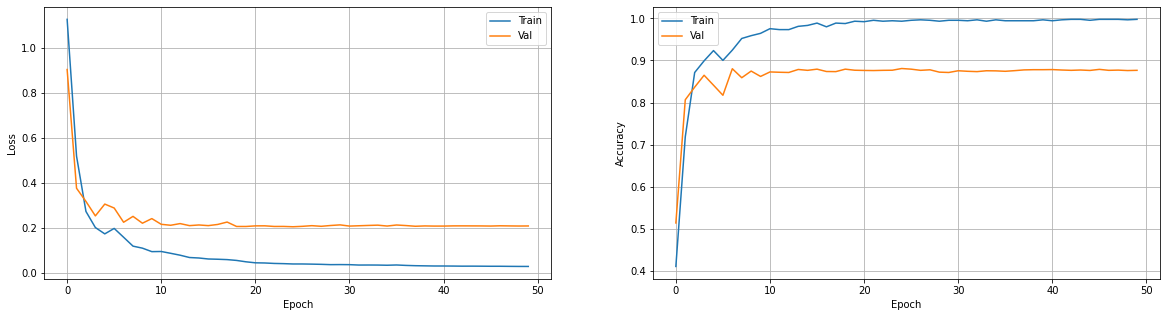

83466 (of 11259978) trainable params
Epoch: 1, train_loss: 1.6890, val_loss: 0.9068, train_acc: 0.4002, val_acc: 0.6572
Epoch: 2, train_loss: 0.6872, val_loss: 0.5532, train_acc: 0.7650, val_acc: 0.8063
Epoch: 3, train_loss: 0.4069, val_loss: 0.6627, train_acc: 0.8614, val_acc: 0.7941
Epoch: 4, train_loss: 0.4149, val_loss: 0.6152, train_acc: 0.8514, val_acc: 0.8226
Epoch: 5, train_loss: 0.3546, val_loss: 0.5844, train_acc: 0.8947, val_acc: 0.8318
Epoch: 6, train_loss: 0.2188, val_loss: 0.5636, train_acc: 0.9268, val_acc: 0.8447
Epoch: 7, train_loss: 0.1342, val_loss: 0.5493, train_acc: 0.9612, val_acc: 0.8514
Epoch: 8, train_loss: 0.1026, val_loss: 0.6236, train_acc: 0.9667, val_acc: 0.8440
Epoch: 9, train_loss: 0.0718, val_loss: 0.6089, train_acc: 0.9745, val_acc: 0.8468
Epoch: 10, train_loss: 0.0818, val_loss: 1.0076, train_acc: 0.9723, val_acc: 0.7941
Epoch: 11, train_loss: 0.2736, val_loss: 0.7698, train_acc: 0.9047, val_acc: 0.8129
Epoch: 12, train_loss: 0.1280, val_loss: 0.6698,

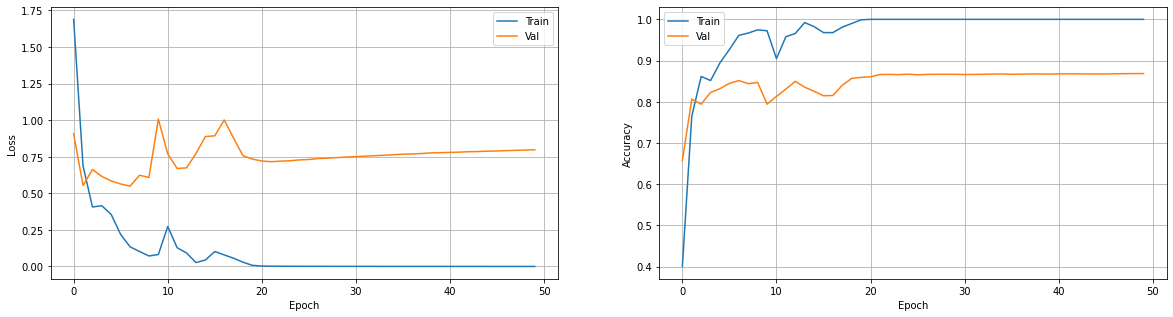

In [57]:
ps = [0.01, 0.05, 0.1]
os.makedirs("./experiments/subset", exist_ok=True)

for p in ps:
    print(f"Training with p = {p}")

    seed_everything(SEED)
    subset = train_val_files[:int(p*len(train_val_files_shuffled))]

    resnet18 = resnet18_student2(N_CLASSES, DEVICE)
    trainable = get_number_of_params(resnet18, trainable=True)
    total = get_number_of_params(resnet18, trainable=False)
    print(f"{trainable} (of {total}) trainable params")
    train_dataset = ImageDataset(subset, LABEL_ENCODER, teacher_labels="./dark_knowledge/resnet101_train_imagewoof.npy")
    test_dataset = ImageDataset(test_files, LABEL_ENCODER, teacher_labels="./dark_knowledge/resnet101_test_imagewoof.npy")
    opt = torch.optim.Adam(resnet18.parameters(), lr=0.01)
    criterion = DistillationLoss(alpha=0.1, temperature=4.0)
    history_resnet18 = train(train_dataset, test_dataset, resnet18, 50, 64, DEVICE, opt, criterion)
    plot_training_history(history_resnet18)
    np.save(f"./experiments/subset/history_resnet18_T_4.0_alpha_0.1_p_{p}.npy", history_resnet18)

    seed_everything(SEED)
    resnet18 = resnet18_student2(N_CLASSES, DEVICE)
    trainable = get_number_of_params(resnet18, trainable=True)
    total = get_number_of_params(resnet18, trainable=False)
    print(f"{trainable} (of {total}) trainable params")
    train_dataset = ImageDataset(subset, LABEL_ENCODER)
    test_dataset = ImageDataset(test_files, LABEL_ENCODER)
    opt = torch.optim.Adam(resnet18.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    history_resnet18_no_teacher = train(train_dataset, test_dataset, resnet18, 50, 64, DEVICE, opt, criterion)
    plot_training_history(history_resnet18_no_teacher)
    np.save(f"./experiments/subset/history_resnet18_no_teacher_p_{p}.npy", history_resnet18_no_teacher)